# Práctica 2 - MLP para funciones lógicas - Lab 2
## Preparación de entorno
#### Instalar las librerías

In [396]:
#%pip install torch torchvision pandas matplotlib

#### Importar librerías de código

In [397]:
import torch # type: ignore
import torch.nn as nn # type: ignore
import torch.optim as optim # type: ignore
from sklearn.metrics import f1_score # type: ignore
from sklearn.preprocessing import StandardScaler, MinMaxScaler # type: ignore
import pandas as pd # type: ignore
import random
import numpy as np # type: ignore
import matplotlib.pyplot as plt # type: ignore
from torch.utils.data import DataLoader, TensorDataset, random_split # type: ignore

### Preparación de los datos de entrenamiento


En primer lugar, importaremos nuestro dataset con pandas, con el fin de crear un dataframe que nos permita trabajar con los datos de forma más cómoda.

In [398]:
df_train = pd.read_csv("data/got_train.csv", usecols=['male', 'isMarried', 'isNoble', 'numDeadRelations', 'isPopular', 'book1','book2','book3','book4','book5', 'alive'])

Una vez tenemos el dataset con las columnas necesarias, dividiremos los datos entre las carácterísticas de entrenamiento y el atributo objetivo, que en este caso es *alive*.

In [399]:
# Características del entrenamiento
x_train = df_train[['male', 'isMarried', 'isNoble', 'numDeadRelations', 'isPopular', 'book1', 'book2', 'book3', 'book4', 'book5']]
# Objetivo
y_train = df_train['alive']
scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train)


Antes de pasar con la definición del modelo, debemos convertir nuestros datos a tensores, de tal manera que podamos trabajar con ellos en PyTorch.  
En el caso del target, al ser un dataset unidimensional, debemos transformarlo a una matriz de una columna y n filas para que sea compatible con las funciones de pérdida y del modelo que usaremos posteriormente.

In [400]:
x_train_tensor = torch.tensor(x_train_scaled, dtype= torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype= torch.float32).view(-1, 1)

## MLP SetUp

Una vez hemos preparado nuestros datos de entrenamiento, procederemos con la definición de nuestro modelo. Para ello, empezaremos definiendo los hiperparámetros.

In [401]:
input_size = x_train_tensor.shape[1] # Número de características de entrada que va a usar el modelo.
hidden_size = 512 # Número de neuronas de la capa oculta
output_size = 1 # Número de nueronas de salida. Ponemos 1 porque va a ser una clasificación binaria (vivo/muerto)

batch_size = 64
learning_rate = 0.001
num_epochs = 150
validation_split = 0.2 

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

Con los hiperparámetros definidos, podemos crear nuestro modelo MLP.

In [402]:
class RedNeuronalGot(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RedNeuronalGot, self).__init__()
        # Capas de la red
        self.capa1 = nn.Linear(input_size, hidden_size)
        self.capa2 = nn.Linear(hidden_size, hidden_size*2)
        self.capa3 = nn.Linear(hidden_size*2, hidden_size)
        self.capa4 = nn.Linear(hidden_size, output_size)

        #Función de activación
        self.relu = nn.ReLU()
        #Función de activación para la capa de salida (binaria)
        self.sigmoid = nn.Sigmoid()
        # Establecemos un dropout para evitar que no hayan neuronas que acaben siendo insignificantes
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.relu(self.capa1(x))
        x = self.dropout(x)
        x = self.relu(self.capa2(x))
        x = self.dropout(x)
        x = self.relu(self.capa3(x))
        x = self.dropout(x)
        x = self.capa4(x)
        x = self.sigmoid(x)  # Aplicamos Sigmoid para obtener un valor entre 0 y 1
        return x

En este caso, hemos decidido utilizar la función de activación Relu para las capas intermedias, y para la capa de salida, la sigmoidea, ya que nos va a sacar siempre un valor entre 0 y 1, que es lo que nos interesa a nosotros para nuestra predicción.  

A continuación, dividiremos los datos de entrenamiento y los de validación.

In [403]:
dataset = TensorDataset(x_train_tensor, y_train_tensor)
dataset_size = len(x_train_tensor)
validation_size = int(validation_split * dataset_size)
train_size = dataset_size - validation_size

train_dataset, val_dataset = random_split(dataset, [train_size, validation_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

Ya con el dataset dividido y adaptado a a PyTorch, podemos proceder instanciando el modelo y definiendo su función de pérdida y optimizador. En este caso, al tratarse de un problema de predicción entre 0 y 1, la función de pérdida más adecuada es **Binary Cross-Entropy Loss**, ya que tiene una menor penalización para los errores más pequeños y tiene un enfoque más probabilístico, que es lo que estamos buscando. [Fuente](https://medium.com/@hatodi0945/a-comparison-between-mse-cross-entropy-and-hinge-loss-4d4fe63cca12#:~:text=The%20MSE%20loss%20is%20therefore,several%20iterations%20of%20model%20training.)

In [404]:
model = RedNeuronalGot(input_size=input_size, hidden_size=hidden_size, output_size=output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay= 0.001)

## MLP Entrenamiento básico

Con los últimos parámetros establecidos, podemos proceder con las funciones previas al entrenamiento. En primer lugar, definiremos la función de evaluación, que medirá el rendimiento de nuestro modelo durante el entrenamiento.

In [405]:
def evaluate_model(model, dataloader, criterion):
    model.eval()
    total_loss = 0
    total_mae = 0
    all_preds = []
    all_trues = []
    
    with torch.no_grad():
        for batch_x, batch_y in dataloader:
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            total_loss += loss.item()
            
            # Error absoluto medio
            mae = (outputs - batch_y).abs().mean().item()
            total_mae += mae
            
            # Guardar predicciones y valores reales para análisis
            all_preds.extend(outputs.cpu().numpy())
            all_trues.extend(batch_y.cpu().numpy())
    
    # Calcular promedios
    avg_loss = total_loss / len(dataloader)
    avg_mae = total_mae / len(dataloader)
    
    # Convertir a numpy arrays para cálculos posteriores
    all_preds = np.array(all_preds).flatten()
    all_trues = np.array(all_trues).flatten()
    
    # Calcular R²
    ss_total = np.sum((all_trues - np.mean(all_trues))**2)
    ss_residual = np.sum((all_trues - all_preds)**2)
    r_squared = 1 - (ss_residual / ss_total) if ss_total != 0 else 0
    
    return avg_loss, avg_mae, r_squared

Antes de empezar a entrenar el modelo, definiremos algunas variables que nos permitirán almacenar información importante relativa al entrenamiento.

In [406]:
# Variables para rastrear las mejores métricas
best_val_loss = float('inf')
best_train_loss = float('inf')
best_val_mae = float('inf')
best_val_r2 = -float('inf')  # R² es mejor cuando es más alto, por eso empezamos con -inf
best_model_state = None

# Listas para almacenar métricas
train_losses = []
val_losses = []
val_maes = []
val_r2s = []

Ya con todo listo, procederemos a entrenar nuestra red neuronal.

In [407]:
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch_x, batch_y in train_loader:
        # Forward
        outputs = model(batch_x.float())
        loss = criterion(outputs, batch_y.float())
        # Back
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    # Pérdida de entrenamiento
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Guardar la mejor pérdida de entrenamiento
    if avg_train_loss < best_train_loss:
        best_train_loss = avg_train_loss

    # Validación
    val_loss, val_mae, val_r2 = evaluate_model(model, val_loader, criterion)
    val_losses.append(val_loss)
    val_maes.append(val_mae)
    val_r2s.append(val_r2)
    
    # Guardar el mejor modelo y las mejores métricas
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict().copy()
    
    if val_mae < best_val_mae:
        best_val_mae = val_mae
    
    if val_r2 > best_val_r2:
        best_val_r2 = val_r2
    
    if (epoch + 1) % 10 == 0:
        print(f'Época [{epoch+1}/{num_epochs}]')
        print(f'Pérdida de entrenamiento: {avg_train_loss:.4f}')
        print(f'Pérdida de validación: {val_loss:.4f}')
        print(f'MAE de validación: {val_mae:.4f}')
        print(f'R² de validación: {val_r2:.4f}')
        print('-' * 50)

# Cargar el mejor modelo
model.load_state_dict(best_model_state)

# Mostrar las mejores métricas al final
print("\n===== MEJORES MÉTRICAS =====")
print(f'Mejor pérdida de entrenamiento: {best_train_loss:.4f}')
print(f'Mejor pérdida de validación: {best_val_loss:.4f}')
print(f'Mejor MAE de validación: {best_val_mae:.4f}')
print(f'Mejor R² de validación: {best_val_r2:.4f}')

Época [10/150]
Pérdida de entrenamiento: 0.0591
Pérdida de validación: 0.0644
MAE de validación: 0.2044
R² de validación: 0.4026
--------------------------------------------------
Época [20/150]
Pérdida de entrenamiento: 0.0586
Pérdida de validación: 0.0630
MAE de validación: 0.1978
R² de validación: 0.4226
--------------------------------------------------
Época [30/150]
Pérdida de entrenamiento: 0.0587
Pérdida de validación: 0.0624
MAE de validación: 0.1957
R² de validación: 0.4288
--------------------------------------------------
Época [40/150]
Pérdida de entrenamiento: 0.0563
Pérdida de validación: 0.0633
MAE de validación: 0.1962
R² de validación: 0.4192
--------------------------------------------------
Época [50/150]
Pérdida de entrenamiento: 0.0559
Pérdida de validación: 0.0620
MAE de validación: 0.1937
R² de validación: 0.4341
--------------------------------------------------
Época [60/150]
Pérdida de entrenamiento: 0.0564
Pérdida de validación: 0.0626
MAE de validación: 0.1

Una vez hemos entrenado la red, podemos realizar una gráfica nos muestre como ha ido evolucionando la pérdida a lo largo del entrenamiento. Esto nos permitirá determinar si nuestra red ha aprendido correctamente, observar si necesita más epochs o si necesitamos cambiar algún hiperparámetro.

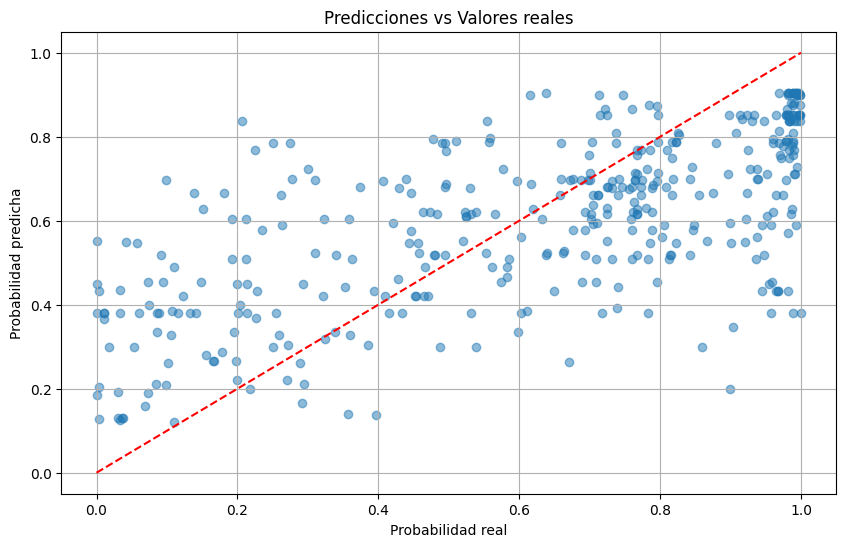

In [408]:
def visualize_predictions(model, dataloader):
    model.eval()
    all_preds = []
    all_trues = []
    
    with torch.no_grad():
        for batch_x, batch_y in dataloader:
            outputs = model(batch_x)
            all_preds.extend(outputs.cpu().numpy())
            all_trues.extend(batch_y.cpu().numpy())
    
    all_preds = np.array(all_preds).flatten()
    all_trues = np.array(all_trues).flatten()
    
    plt.figure(figsize=(10, 6))
    plt.scatter(all_trues, all_preds, alpha=0.5)
    plt.plot([0, 1], [0, 1], 'r--')  # Línea diagonal perfecta
    plt.xlabel('Probabilidad real')
    plt.ylabel('Probabilidad predicha')
    plt.title('Predicciones vs Valores reales')
    plt.grid(True)
    plt.show()

# Usar después del entrenamiento
visualize_predictions(model, val_loader)

## MLP Evaluación final